# Build Market Movement Classifier. 

In [1]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf
import spacy 
import xgboost as xgb
import shap 
import optuna 
from optuna import visualization as opt_viz 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import ElasticNet 
from sklearn.metrics import mean_squared_error 
from feature_engine.encoding import OneHotEncoder 

# Change the current directory from (./notebook) to root directory. 
if not re.match(r".+/MADS-M2-estimating-news-impact-on-financial-market$", os.getcwd()): 
	os.chdir("../..") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles 
from source.modules import visualizer 
from source.modules.processor_topic import raw_token_input 
from source.modules.processor_estim import (
	ColumnSelector, ExtractSentiment, ExtractTopic, 
	search_opt, multiverse_analysis 
) 

# Custom configs. 
from source.config_py.config import (
	DIR_MLSPACY, DIR_MLTOPIC, DIR_MLESTIM, 
	TICKER_TO_COLLECT, TICKER_DATE_COLLECT, 
	PARAM_SEED, EXPERIMENT_TRIAL 
)

# Preview. 
print(os.getcwd()) 

/Users/lioneltay/.local/share/virtualenvs/MADS-M2-estimating-news-impact-on-financia-G1YPmgZm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_694_695_milestone_2_Eric_Gilbert/submission/MADS-M2-estimating-news-impact-on-financial-market


## Configurations (general). 

In [2]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# For clearing the output. Not important. 
clear_output()

## Load ticker data. 

In [3]:
df_tickers = pd.DataFrame() 

# Get the ticker class object. 
tickers = [(t, yf.Ticker(t)) for t in TICKER_TO_COLLECT] 

for tname, tobject in tickers: 
	tname = tname.lower() 

	# Get the ticker history data. 
	df_ticker = tobject.history(period="max", interval="1d", start=TICKER_DATE_COLLECT[0], end=TICKER_DATE_COLLECT[1], auto_adjust=True, rounding=True) 

	# Rename the columns. 
	df_ticker.columns = [f"{tname}_{c}".lower().replace(" ", "_") for c in df_ticker.columns] 

	# Keep specific columns only. 
	usecols = [f"{tname}_open", f"{tname}_close", f"{tname}_volume"] 

	# Concat the columns. 
	df_tickers = pd.concat([df_tickers, df_ticker[usecols]], axis="columns") 

# Preview. 
df_tickers

,spy_open,spy_close,spy_volume
Date,,,
1998-11-30,77.91,76.02,8705400
1998-12-01,76.02,77.00,8950600
1998-12-02,76.74,76.78,7495500
1998-12-03,76.76,75.51,12145300
1998-12-04,76.35,77.49,10339500
...,...,...,...
2022-03-14,419.59,415.71,95729200
2022-03-15,418.47,424.85,106219100
2022-03-16,428.56,434.27,144954800


## Preprocess ticker data. 

### Create labels (rolling t-score). 

In [4]:
# Define the rolling window and min period. 
window_avg, window_std = 365, 365 
period_avg, period_std = 365, 365 

# Define market movement scale. 
mv_lo, mv_hi = 0.25, 0.75 

# Create labels for each ticker symbol. 
for tname in TICKER_TO_COLLECT: 
	tname = tname.lower() 

	# # Compute the log return of the ticker price. 
	df_tickers[f"{tname}_logret_c2c"] = np.log(df_tickers[f"{tname}_close"]) - np.log(df_tickers[f"{tname}_close"].shift(1)) 
	# df_tickers[f"{tname}_logret_o2c"] = np.log(df_tickers[f"{tname}_close"]) - np.log(df_tickers[f"{tname}_open"]) 
	# df_tickers[f"{tname}_logret_c2o"] = np.log(df_tickers[f"{tname}_open"].shift(-1)) - np.log(df_tickers[f"{tname}_close"]) 

	# Compute the tscore for price change. Ignore negative sign since we are interested in the movement, not direction. 
	logret_c2c_ravg = df_tickers[f"{tname}_logret_c2c"].rolling(window=window_avg, min_periods=period_avg, win_type=None).mean() 
	logret_c2c_rstd = df_tickers[f"{tname}_logret_c2c"].rolling(window=window_std, min_periods=period_std, win_type=None).std(ddof=1) 
	df_tickers[f"{tname}_tscore_c2c"] = ((df_tickers[f"{tname}_logret_c2c"] - logret_c2c_ravg) / logret_c2c_rstd).abs() 

	# Define the market movement scale. 
	df_tickers[f"{tname}_mktmv_c2c"] = 1
	df_tickers.loc[df_tickers[f"{tname}_tscore_c2c"] >= 0.75, f"{tname}_mktmv_c2c"] = 2
	df_tickers.loc[df_tickers[f"{tname}_tscore_c2c"] <= 0.25, f"{tname}_mktmv_c2c"] = 0

# Create autocorrsselated features for the past N days. 
for shift in range(1,4,1): 
	df_tickers[f"spy_tscore_c2c_lag_{shift}"] = df_tickers["spy_tscore_c2c"].shift(shift) 

# Lowercase the name. 
df_tickers.index.name = df_tickers.index.name.lower() 

# Preview. 
df_tickers

,spy_open,spy_close,spy_volume,spy_logret_c2c,spy_tscore_c2c,spy_mktmv_c2c,spy_tscore_c2c_lag_1,spy_tscore_c2c_lag_2,spy_tscore_c2c_lag_3
date,,,,,,,,,
1998-11-30,77.91,76.02,8705400,NaN,NaN,1,NaN,NaN,NaN
1998-12-01,76.02,77.00,8950600,0.012809,NaN,1,NaN,NaN,NaN
1998-12-02,76.74,76.78,7495500,-0.002861,NaN,1,NaN,NaN,NaN
1998-12-03,76.76,75.51,12145300,-0.016679,NaN,1,NaN,NaN,NaN
1998-12-04,76.35,77.49,10339500,0.025884,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-03-14,419.59,415.71,95729200,-0.007334,0.843413,2,1.424431,0.555996,2.713005
2022-03-15,418.47,424.85,106219100,0.021748,2.210934,2,0.843413,1.424431,0.555996
2022-03-16,428.56,434.27,144954800,0.021930,2.209529,2,2.210934,0.843413,1.424431


### Visualize the label distribution. 

In [5]:
print(df_tickers["spy_mktmv_c2c"].value_counts(normalize=True)) 

visualizer.plot_discre_dist(df_tickers, x="spy_mktmv_c2c") 

1    0.403138
2    0.326228
0    0.270634
Name: spy_mktmv_c2c, dtype: float64


alt.Chart(...)

Text(0.5, 1.0, 'spy_tscore_c2c')

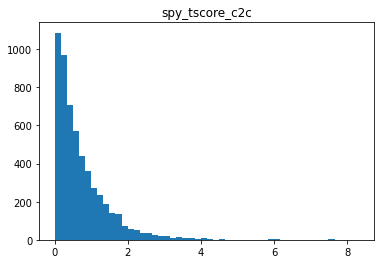

In [6]:
colname = "spy_tscore_c2c" 

plt.hist(x=df_tickers[colname], bins=50) 
plt.title(colname) 

## Load news dataset with entities. 

In [7]:
# Load dataset. 
df_business = manage_files.read_from_parquet(filename="cnn_news_business.parquet") 

# FIlter columns
usecols = ["date", "category", "section", "headline", "second_headline", "description", "article_text", "entities"] 
df_business = df_business[usecols] 

# Get entities text. 
df_business["theme_sub"] = df_business["entities"].str["title"] 

# Preview. 
df_business 

Read from (cnn_news_business.parquet)


,date,category,section,headline,second_headline,description,article_text,entities,theme_sub
headline_id,,,,,,,,,
3,2022-03-18,business,success,"Two years later, remote work has changed milli...","Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,The pandemic thrust the working world into a n...,"{'characters': [[[ 0 11], [ 4 11], [922 933], ...","[COVID-19 pandemic, Employment, World, Learnin..."
4,2022-03-19,business,investing,Why March is so volatile for stocks - CNN,Why March is so volatile for stocks,March Madness isn't just for college basketbal...,New York (CNN Business)March Madness isn't jus...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, C..."
5,2022-03-20,business,investing,Stocks week ahead: Big Oil rakes in billions a...,Big Oil rakes in billions as prices soar. Lawm...,"As crude prices surge, oil companies are rakin...",A version of this story first appeared in CNN ...,"{'characters': [[[42 44], [140 142], [6077 607...","[CNN, CNN Business, Business, Human rights, Ne..."
6,2022-03-18,business,energy,Oil 'emergency': Work from home and drive slow...,Oil 'emergency': Work from home and drive slow...,Governments around the world must consider dra...,New York (CNN Business)Governments around the ...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, G..."
7,2022-03-20,business,perspectives,Opinion: Technology is transforming the nature...,Technology is transforming the nature of money...,The convenience of digital payments to both co...,This interview has been edited from its origin...,"{'characters': [[[105 137], [109 137], [728 75...","[International Monetary Fund, Money, Finance, ..."
...,...,...,...,...,...,...,...,...,...
10407,2022-01-13,business,business,Nation's top trade groups hail SCOTUS ruling a...,Nation's top trade groups hail SCOTUS ruling a...,The nation's largest industry trade groups are...,(CNN Business)The nation's largest industry t...,"{'characters': [[[2 4]], [[ 2 13]], [[ 6 13], ...","[CNN, CNN Business, Business, Industrial Revol..."
10408,2022-01-04,business,business,Port of Los Angeles traffic sets record - CNN,Port of Los Angeles traffic sets record in 2021,A record-setting 10.7 million 20-foot containe...,(CNN)A record-setting 10.7 million 20-foot co...,"{'characters': [[[2 4]], [[74 77], [233 236], ...","[CNN, Port, Port of Los Angeles, Los Angeles, ..."
10409,2021-12-06,business,business,"Ford delays return to office for 30,000 worker...","Ford delays return to office for 30,000 worker...",Ford Motor Co. is pushing its return-to-office...,New York (CNN Business)Ford Motor Co. is pushi...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York (state), CNN, CNN Business, Business..."


### Merge with ticker data. 

In [8]:
# Make a copy to avoid overwriting the original. 
df_marketnews = df_business.copy() 

# Merge the columns. 
usecols = ["spy_mktmv_c2c", "spy_tscore_c2c"] + [f"spy_tscore_c2c_lag_{lag}" for lag in range(1,4,1)] 
df_marketnews = df_marketnews.merge(right=df_tickers[usecols], how="left", left_on="date", right_index=True) 

# Preview. 
df_marketnews

,date,category,section,headline,second_headline,description,article_text,entities,theme_sub,spy_mktmv_c2c,spy_tscore_c2c,spy_tscore_c2c_lag_1,spy_tscore_c2c_lag_2,spy_tscore_c2c_lag_3
headline_id,,,,,,,,,,,,,,
3,2022-03-18,business,success,"Two years later, remote work has changed milli...","Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,The pandemic thrust the working world into a n...,"{'characters': [[[ 0 11], [ 4 11], [922 933], ...","[COVID-19 pandemic, Employment, World, Learnin...",2.0,1.056214,1.220959,2.209529,2.210934
4,2022-03-19,business,investing,Why March is so volatile for stocks - CNN,Why March is so volatile for stocks,March Madness isn't just for college basketbal...,New York (CNN Business)March Madness isn't jus...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, C...",NaN,NaN,NaN,NaN,NaN
5,2022-03-20,business,investing,Stocks week ahead: Big Oil rakes in billions a...,Big Oil rakes in billions as prices soar. Lawm...,"As crude prices surge, oil companies are rakin...",A version of this story first appeared in CNN ...,"{'characters': [[[42 44], [140 142], [6077 607...","[CNN, CNN Business, Business, Human rights, Ne...",NaN,NaN,NaN,NaN,NaN
6,2022-03-18,business,energy,Oil 'emergency': Work from home and drive slow...,Oil 'emergency': Work from home and drive slow...,Governments around the world must consider dra...,New York (CNN Business)Governments around the ...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, G...",2.0,1.056214,1.220959,2.209529,2.210934
7,2022-03-20,business,perspectives,Opinion: Technology is transforming the nature...,Technology is transforming the nature of money...,The convenience of digital payments to both co...,This interview has been edited from its origin...,"{'characters': [[[105 137], [109 137], [728 75...","[International Monetary Fund, Money, Finance, ...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10407,2022-01-13,business,business,Nation's top trade groups hail SCOTUS ruling a...,Nation's top trade groups hail SCOTUS ruling a...,The nation's largest industry trade groups are...,(CNN Business)The nation's largest industry t...,"{'characters': [[[2 4]], [[ 2 13]], [[ 6 13], ...","[CNN, CNN Business, Business, Industrial Revol...",2.0,1.646759,0.182634,0.890728,0.255698
10408,2022-01-04,business,business,Port of Los Angeles traffic sets record - CNN,Port of Los Angeles traffic sets record in 2021,A record-setting 10.7 million 20-foot containe...,(CNN)A record-setting 10.7 million 20-foot co...,"{'characters': [[[2 4]], [[74 77], [233 236], ...","[CNN, Port, Port of Los Angeles, Los Angeles, ...",0.0,0.165529,0.516861,0.401643,0.429065
10409,2021-12-06,business,business,"Ford delays return to office for 30,000 worker...","Ford delays return to office for 30,000 worker...",Ford Motor Co. is pushing its return-to-office...,New York (CNN Business)Ford Motor Co. is pushi...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York (state), CNN, CNN Business, Business...",2.0,1.181054,1.099127,1.551140,1.349769


## Resolve nulls. 

In [9]:
# Some news may occur during the weekends. Hence the null. 
df_marketnews.shape, df_marketnews.isnull().sum() 

((854, 14),
 date                     0
 category                 0
 section                  0
 headline                 0
 second_headline          0
 description              0
 article_text             0
 entities                 0
 theme_sub               10
 spy_mktmv_c2c           95
 spy_tscore_c2c          95
 spy_tscore_c2c_lag_1    95
 spy_tscore_c2c_lag_2    95
 spy_tscore_c2c_lag_3    95
 dtype: int64)

In [10]:
print("Total nulls befr drop: ") 
print(df_marketnews.isnull().sum(), "\n", "-----" * 5, "\n") 

# Remove any emtpy rows. 
dropcols = ["theme_sub", "spy_mktmv_c2c", "spy_tscore_c2c"] 
df_marketnews = df_marketnews.dropna(subset=dropcols, axis="index") 
print("Total nulls aftr drop: ")
print(df_marketnews.isnull().sum(), "\n", "-----" * 5, "\n") 

# Preview. 
df_marketnews.shape 

Total nulls befr drop: 
date                     0
category                 0
section                  0
headline                 0
second_headline          0
description              0
article_text             0
entities                 0
theme_sub               10
spy_mktmv_c2c           95
spy_tscore_c2c          95
spy_tscore_c2c_lag_1    95
spy_tscore_c2c_lag_2    95
spy_tscore_c2c_lag_3    95
dtype: int64 
 ------------------------- 

Total nulls aftr drop: 
date                    0
category                0
section                 0
headline                0
second_headline         0
description             0
article_text            0
entities                0
theme_sub               0
spy_mktmv_c2c           0
spy_tscore_c2c          0
spy_tscore_c2c_lag_1    0
spy_tscore_c2c_lag_2    0
spy_tscore_c2c_lag_3    0
dtype: int64 
 ------------------------- 



(749, 14)

## Feature extraction. 

### Extract sentiment score. 

In [11]:
# # Uncomment this part if you want to preview how it is done. 
# # This part is include in the ML pipeline so you don't need 
# # to run this part. 

# # Load the best model. 
# mlpipe_spacy = spacy.load(f"{DIR_MLSPACY}/model-best") 

# # Extract sentiment score. 
# df_marketnews["sentiment_score"] = df_marketnews.apply(lambda x: mlpipe_spacy(x["headline"]).cats, axis="columns") 
# df_marketnews["sentiment"] = df_marketnews["sentiment_score"].apply(lambda x: max(x, key=x.get)) 

# # Will raise warnigns due to SettingWithCopyWriting, but not an issue. 
# clear_output() 

# # Preview. 
# df_marketnews 

### Extract topics or themes. 

In [12]:
# # Uncomment this part if you want to preview how it is done. 
# # This part is include in the ML pipeline so you don't need 
# # to run this part. 

# mlpipe_name = "mlpipe_topic" 
# mlpipe_topic = manage_files.load_version_pk(dir=DIR_MLTOPIC, obj_name=mlpipe_name, version_load="latest") 

# # Extract topics or themes. 
# df_marketnews["theme"] = np.argmax(mlpipe_topic.transform(df_marketnews["theme_sub"]), axis=1) 
# df_marketnews["theme"] = "topic_" + df_marketnews["theme"].astype("str") 

# # Will raise warnigns due to SettingWithCopyWriting, but not an issue. 
# clear_output() 

# # Preview. 
# df_marketnews 

## Develop models. 

### Split train test. 

In [13]:
usecols = ["headline", "theme_sub"] + [f"spy_tscore_c2c_lag_{lag}" for lag in range(1,4,1)] 
X, y = df_marketnews[usecols], df_marketnews["spy_tscore_c2c"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=PARAM_SEED, shuffle=True) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(599, 5) (150, 5) (599,) (150,)


### Multiverse Analysis. 

In [14]:
# Load SpaCy pipeline. 
mlpipe_spacy = spacy.load(f"{DIR_MLSPACY}/model-best") 

# Load Topic model pipeline. 
mlpipe_name = "mlpipe_topic" 
mlpipe_topic = manage_files.load_version_pk(dir=DIR_MLTOPIC, obj_name=mlpipe_name, version_load="latest") 

Load object (mlpipe_topic).
Resumed version: (2) from (dev)


In [15]:
# # Uncomment this part if you want to rerun the multiverse analysis. 
# # Take about 90 minutes to run 50 trials. 50 minutes for 25 trials. 
# # SearchCV will automatically stops running the trial if the 
# # optimisation reaches a plateau. 

# # Perform multiverse analysis. 
# kwargs = dict(mlpipe_spacy=mlpipe_spacy, mlpipe_topic=mlpipe_topic) 
# df_performances = multiverse_analysis(X_train, y_train, n_trials=EXPERIMENT_TRIAL, verbose=0, **kwargs) 

# # The scoring method is negative RMSE so we need to "absolute" it. 
# df_performances["rmse_avg"] = df_performances["rmse_avg"].abs() 
# df_performances = df_performances.sort_values(["rmse_avg", "rmse_std"], ascending=False, ignore_index=True) 

# # Compute the interval range. 
# df_performances["rmse_min"] = df_performances["rmse_avg"] - (df_performances["rmse_std"] * 2) 
# df_performances["rmse_max"] = df_performances["rmse_avg"] + (df_performances["rmse_std"] * 2) 

# # Preview. 
# df_performances 

In [16]:
# # # Save the regression model performance record. 
# manage_files.save_cache_pk(dir="dataset", filename="regression_performance.pickle", object=df_performances) 

# Load the past regression model performance record. 
df_performances = manage_files.load_cache_pk(dir="dataset", filename="regression_performance.pickle") 

# Preview. 
df_performances 

Load from (regression_performance.pickle)


,est_names,estimator,component,rmse_avg,rmse_std,ml_n_comp,feat_name,rmse_min,rmse_max
0,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...",['sentiment'],0.788474,0.087716,xgb + ['sentiment'],[headline],0.613042,0.963905
1,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...",['sentiment'],0.788381,0.085958,rfr + ['sentiment'],[headline],0.616466,0.960296
2,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...",['newstheme'],0.788168,0.085435,els + ['newstheme'],[theme_sub],0.617297,0.959039
3,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...",['sentiment'],0.788168,0.085435,els + ['sentiment'],[headline],0.617297,0.959039
4,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...","['newstheme', 'sentiment']",0.788168,0.085435,"els + ['newstheme', 'sentiment']","[theme_sub, headline]",0.617297,0.959039
5,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","['newstheme', 'sentiment']",0.762123,0.091437,"xgb + ['newstheme', 'sentiment']","[theme_sub, headline]",0.579249,0.944998
6,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...","['newstheme', 'sentiment']",0.760429,0.08848,"rfr + ['newstheme', 'sentiment']","[theme_sub, headline]",0.583469,0.937388
7,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...",['newstheme'],0.760155,0.089374,rfr + ['newstheme'],[theme_sub],0.581408,0.938903
8,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...",['newstheme'],0.759491,0.091034,xgb + ['newstheme'],[theme_sub],0.577422,0.94156
9,els,"ElasticNet(alpha=1, l1_ratio=0.1, max_iter=500...",['autocorrs'],0.739315,0.086762,els + ['autocorrs'],"[spy_tscore_c2c_lag_1, spy_tscore_c2c_lag_2, s...",0.565791,0.912839


In [17]:
usecols = ["rmse_avg", "ml_n_comp", "rmse_min", "rmse_max"] 
visualizer.plot_multiverse_analysis(df_performances[usecols], x="rmse_avg", y="ml_n_comp", err_minmax=("rmse_min", "rmse_max")) 

alt.LayerChart(...)

### Rebuild the model selecting the approach. 

In [18]:
index = 17 

# Get the feature from the top performing model. 
usecols = df_performances.loc[index, "feat_name"] 

# Get the best estimator. 
estimator = df_performances.loc[index, "estimator"] 

# Model pipeline setup. 
mlpipe_estim = Pipeline([
	("select_col", ColumnSelector(var_proc=usecols)), 
	("extract_newstheme", ExtractTopic(est_pipe=mlpipe_topic, var_proc="theme_sub", var_name="theme")), 
	("extract_sentiment", ExtractSentiment(est_pipe=mlpipe_spacy, var_proc="headline", var_name="sentiment")), 
	("oh_encoder", OneHotEncoder(drop_last=True, variables=["theme", "sentiment"])), 
]) 

X_train_feature = mlpipe_estim.fit_transform(X_train) 

# Clear safe warnings. Not important. 
clear_output() 

# Convert to dataframe. 
df_features = pd.DataFrame(X_train_feature, columns=mlpipe_estim["oh_encoder"].get_feature_names_out()) 

# Preview. 
df_features 

,spy_tscore_c2c_lag_1,spy_tscore_c2c_lag_2,spy_tscore_c2c_lag_3,theme_topic_2,theme_topic_0,theme_topic_7,theme_topic_4,theme_topic_5,theme_topic_3,theme_topic_1,sentiment_neutral,sentiment_positive
headline_id,,,,,,,,,,,,
7125,1.721244,0.354130,2.260570,1,0,0,0,0,0,0,1,0
857,0.360439,0.014939,0.273903,0,1,0,0,0,0,0,0,1
239,0.622194,1.857452,1.721244,0,0,1,0,0,0,0,1,0
761,0.725346,0.773573,0.473836,0,1,0,0,0,0,0,1,0
8610,2.164071,1.994815,1.460552,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.451623,0.394696,0.020143,0,0,0,0,0,1,0,1,0
830,0.504649,1.405984,0.844810,0,0,0,0,0,1,0,0,1
1031,0.343569,0.238661,0.370219,0,0,1,0,0,0,0,1,0


In [19]:
# # Uncomment this part if you wanna use this. 

# # Elastic Net. We assume to have many low coefficient features, so 
# # L2 penalty would be more appropriate for regularization in out case 
# # if it is needed. 
# estimator_els = ElasticNet(alpha=1, l1_ratio=.5, max_iter=5000, random_state=PARAM_SEED) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "l1_ratio"  : [.5, .3, .1], 
# } 

# searchres = search_opt(estimator_els, X_train_feature, y_train, param_dist, bayes=False, n_trials=100, verbose=0) 

In [20]:
# # Uncomment this part if you wanna use this. 

# '''
# Documentation and tutorials: 
#     - https://xgboost.readthedocs.io/en/latest/parameter.html 
# ''' 

# # XGBoost. 
# estimator_xgb = xgb.XGBRegressor(
# 	learning_rate=0.001, n_estimators=100, max_depth=8, base_score=0.5, 
#     reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05, min_child_weight=1, 
#     subsample=0.5, tree_method="auto", booster="gbtree", num_parallel_tree=2, 
#     objective="reg:squarederror", eval_metric="rmse", seed=PARAM_SEED, 
# ) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "learning_rate"     : optuna.distributions.LogUniformDistribution(1e-4, 1e-2), 
#     "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
#     "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
#     "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
# }

# searchres = search_opt(estimator_xgb, X_train_feature, y_train, param_dist, n_trials=50, verbose=0) 

In [21]:
# # Uncomment this part if you wanna use this. 

# '''
# Documentation and tutorials: 
#     - https://xgboost.readthedocs.io/en/stable/tutorials/rf.html 
# ''' 

# # Standalone Random Forest API. 
# estimator_rfr = xgb.XGBRFRegressor(
# 	learning_rate=1, n_estimators=100, max_depth=8, base_score=0.5, 
#     colsample_bynode=.5, reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05,
#     min_child_weight=1, subsample=0.5, tree_method="auto", booster="gbtree", 
#     num_parallel_tree=2, objective="reg:squarederror", eval_metric="rmse", 
#     seed=PARAM_SEED, 
# ) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
#     "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
#     "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
# }

# searchres = search_opt(estimator_rfr, X_train_feature, y_train, param_dist, n_trials=1, verbose=0) 

### Model evaluation. 

In [22]:
# # Assign the best estimator if you retrain the model again. 
# estimator = searchres.best_estimator_ 

# Make prediction. 
base_score = y_train.mean() 
predicted = estimator.predict(X_train_feature) 

# Compare the prediction score. 
base_rmse = np.sqrt( mean_squared_error(y_train, [base_score] * len(y_train), squared=True) ) 
pred_rmse = np.sqrt( mean_squared_error(y_train, predicted, squared=True) ) 

print("Base RMSE: ", base_rmse) 
print("Pred RMSE: ", pred_rmse) 

Base RMSE:  0.7907548413046536
Pred RMSE:  0.3906016564034625


In [23]:
df_predicted = pd.DataFrame(data={"true": y_train, "pred": predicted}) 
df_predicted.corr(method="pearson") 

,true,pred
true,1.000000,0.882795
pred,0.882795,1.000000


In [24]:
visualizer.plot_correlation(df_predicted, x="pred", y="true", xlim=(0,4), ylim=(0,4)) 

alt.LayerChart(...)

### Model interpretation. 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


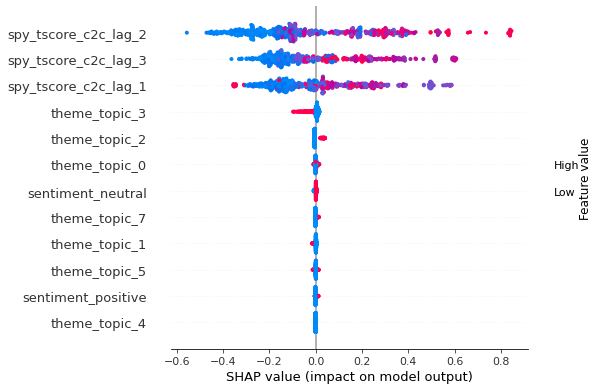

In [25]:
'''
Documentation and tutorials: 
	- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models.html
	- https://github.com/slundberg/shap 
	- https://analyticsindiamag.com/a-complete-guide-to-shap-shapley-additive-explanations-for-practitioners/
'''

explainer = shap.TreeExplainer(estimator) 
shap_values = explainer(df_features) 

# Visualise the feature weight and important for the entire rows. 
shap.plots.beeswarm(shap_values, max_display=20) 

In [26]:
# # SHAP. Visualise the feature weight for a single row. 
# shap.plots.waterfall(shap_values[0]) 
# shap.plots.waterfall(shap_values[1]) 
# shap.plots.waterfall(shap_values[2]) 

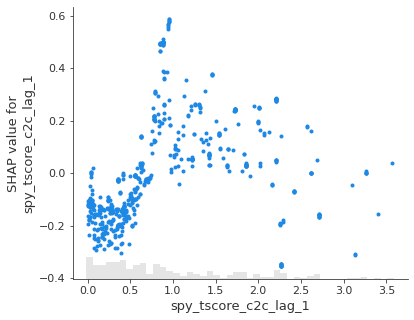

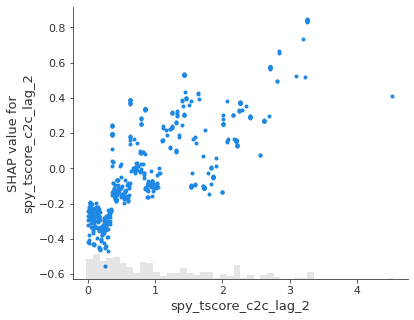

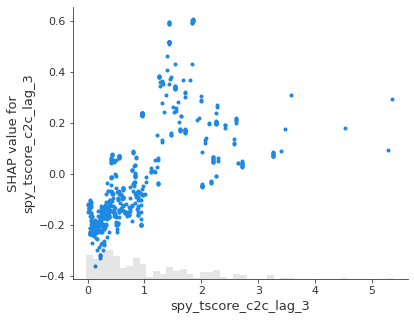

In [27]:
# SHAP. Visualise the feature weight trend for each feature. 
shap.plots.scatter(shap_values[:,0]) 
shap.plots.scatter(shap_values[:,1]) 
shap.plots.scatter(shap_values[:,2]) 

### Save the models. 

In [28]:
# # Cache the vectorized output. 
# mlpipe_name = "mlpipe_estim" 
# manage_files.save_version_pk(dir=DIR_MLESTIM, obj_name=mlpipe_name, object=mlpipe_topic) 
# mlpipe_estim_loaded = manage_files.load_version_pk(dir=DIR_MLESTIM, obj_name=mlpipe_name, version_load="latest") 